SVR model with Polynominial Regression (Hybrid Modelling) by incorporating fluctuation like Covid-19 to negate quadratic line issues

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Load data
data = pd.read_csv('Data/cloneData.csv')

# Initialize scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale input and target variables
X = data[['year', 'population', 'gdp', 'householdMinIncome', 'death']]
y = data['waste'].values.reshape(-1, 1)
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Train the SVR model
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
best_svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
best_svr.fit(X_train, y_train.ravel())

# Step 1: Trend Model (Polynomial Regression)
poly = PolynomialFeatures(degree=2)
trend_data = data[['year', 'waste']].dropna()
X_trend = poly.fit_transform(trend_data[['year']])
trend_model = LinearRegression()
trend_model.fit(X_trend, trend_data['waste'])

# Step 2: Event Impact Model
data['covid_dummy'] = np.where(data['year'].between(2020, 2021), 1, 0)
X_event = data[['year', 'covid_dummy']].values
event_model = LinearRegression()
event_model.fit(X_event, data['waste'])

# Predict future features using polynomial regression for `population`, `gdp`, etc.
predicted_features = ['population', 'gdp', 'householdMinIncome', 'death']
feature_predictions = {}
degree = 2
for feature in predicted_features:
    if feature in data.columns:
        poly = PolynomialFeatures(degree=degree)
        trend_data = data[['year', feature]].dropna()
        X_poly = poly.fit_transform(trend_data[['year']])

        # Train polynomial regression model
        poly_model = LinearRegression()
        poly_model.fit(X_poly, trend_data[feature])

        # Predict future values
        prediction_years = pd.DataFrame({'year': list(range(2025, 2051))})
        X_future_poly = poly.transform(prediction_years[['year']])
        feature_predictions[feature] = poly_model.predict(X_future_poly)

# Step 3: Predict Future Waste
temp_prediction_data = pd.DataFrame({
    'year': list(range(2025, 2051))
})
for feature in predicted_features:
    temp_prediction_data[feature] = feature_predictions.get(feature, [0] * len(temp_prediction_data))
temp_prediction_data['covid_dummy'] = 0  # Assuming no future COVID-like events

# Combine Trend and Event Models
X_future_trend = poly.transform(temp_prediction_data[['year']])
X_future_event = temp_prediction_data[['year', 'covid_dummy']].values
trend_predictions = trend_model.predict(X_future_trend)
event_predictions = event_model.predict(X_future_event)
final_predictions = trend_predictions + event_predictions

# Add waste predictions to the DataFrame
temp_prediction_data['predicted_waste'] = final_predictions

# Scale and Predict using SVR
X_prediction_scaled = scaler_X.transform(temp_prediction_data[['year', 'population', 'gdp', 'householdMinIncome', 'death']])
y_prediction_scaled = best_svr.predict(X_prediction_scaled)
y_prediction = scaler_y.inverse_transform(y_prediction_scaled.reshape(-1, 1)).ravel()
temp_prediction_data['predicted_waste_svr'] = y_prediction

# Save predictions to CSV
temp_prediction_data.to_csv('Hybrid_Waste_Predictions_2025_to_2050.csv', index=False)

# Display results
print(temp_prediction_data)


    year    population           gdp  householdMinIncome          death  \
0   2025  3.402000e+07  1.673647e+06         8833.980000  219012.135654   
1   2026  3.424554e+07  1.729595e+06         8989.796923  226550.908497   
2   2027  3.445527e+07  1.786386e+06         9145.613846  234313.947932   
3   2028  3.464918e+07  1.844020e+06         9301.430769  242301.253959   
4   2029  3.482729e+07  1.902496e+06         9457.247692  250512.826579   
5   2030  3.498960e+07  1.961816e+06         9613.064615  258948.665791   
6   2031  3.513609e+07  2.021979e+06         9768.881538  267608.771596   
7   2032  3.526678e+07  2.082985e+06         9924.698462  276493.143992   
8   2033  3.538165e+07  2.144834e+06        10080.515385  285601.782982   
9   2034  3.548072e+07  2.207525e+06        10236.332308  294934.688563   
10  2035  3.556399e+07  2.271060e+06        10392.149231  304491.860737   
11  2036  3.563144e+07  2.335437e+06        10547.966154  314273.299503   
12  2037  3.568309e+07  2

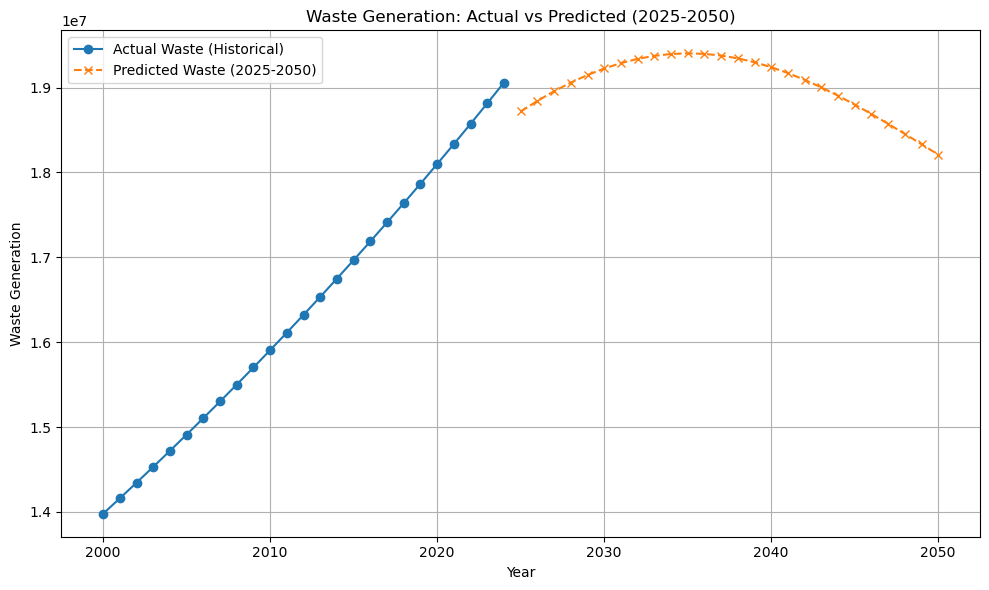

In [2]:
import matplotlib.pyplot as plt

# Load the predicted data
predicted_data = pd.read_csv('Waste_Predictions_2025_to_2050.csv')

# Combine actual and predicted data for visualization
visualization_data = pd.concat([
    data[['year', 'waste']].rename(columns={'waste': 'actual_waste'}),
    predicted_data[['year', 'predicted_waste']].rename(columns={'predicted_waste': 'waste'})
], ignore_index=True, sort=False)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(
    data['year'], 
    data['waste'], 
    label='Actual Waste (Historical)', 
    marker='o'
)
plt.plot(
    predicted_data['year'], 
    predicted_data['predicted_waste'], 
    label='Predicted Waste (2025-2050)', 
    linestyle='--', 
    marker='x'
)

# Customize the plot
plt.title('Waste Generation: Actual vs Predicted (2025-2050)')
plt.xlabel('Year')
plt.ylabel('Waste Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on test data
y_test_pred = best_svr.predict(X_test)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Metrics
mae = mean_absolute_error(y_test_rescaled, y_test_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_test_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_test_pred_rescaled)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 299354.324674277
Mean Squared Error (MSE): 121488044688.48071
R² Score: 0.953881312940209
